In [1]:
%pylab inline
import pandas as pd
import sympy as sp

sp.init_printing(use_latex = True)

Populating the interactive namespace from numpy and matplotlib


# Lecture 4: Rootfinding and Interpolation

## Topics
* Root finding
* Interpolation
* Curve building

$\renewcommand{bs}{\boldsymbol}$

# Rootfinding

* The Bible: the love of money is the root of all evil
* Mark Twain: the lack of money is the root of all evil
* Ayn Rand：money is the root of all good

## Common rootfinding methods

Search the root of a scalar function $f(x) = 0$, common methods:

* Bisection
* Newton-Ralphson
* Secant
* Brent

## Illustrative Examples: 

* compute the implied volatility of a call option.
* a more challenging problem of $\Phi(x) + .05x - 0.5 = 0$

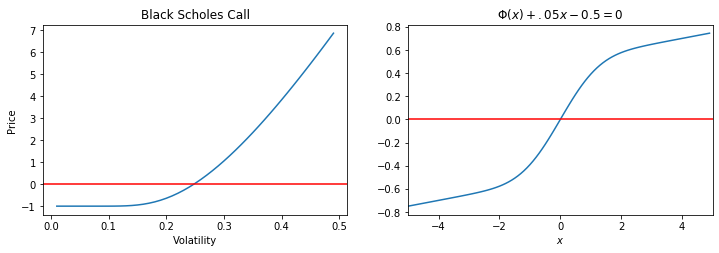

In [2]:
from scipy.stats import norm
lecture = 4

# black scholes call
def bs_call(r, s, k, sigma, t) :
    d1 = (math.log(s/k) + (r + .5*sigma*sigma)*t)/sigma/math.sqrt(t)
    d2 = d1 - sigma*math.sqrt(t)
    return norm.cdf(d1)*s - norm.cdf(d2)*k*math.exp(-r*t)

# black scholes vega
def bs_vega(r, s, k, sigma, t) :
    d1 = (math.log(s/k) + (r + .5*sigma*sigma)*t)/sigma/math.sqrt(t)
    return math.sqrt(t)*s*norm.pdf(d1)

f = lambda s : bs_call(r=.05, s=100, k=150., sigma=s, t=1) - 1.
g = lambda s, foo, bar : bs_vega(r=.05, s=100, k=150., sigma=s, t=1) 
f2 = lambda x : norm.cdf(x) + .05*x - .5
g2 = lambda x, a, b : norm.pdf(x) + .05

fig = figure(figsize=[12, 3.5])
subplot(1, 2, 1)
sigs = np.arange(.01, .5, .01)
bsv = np.array([f(s) for s in sigs])
plot(sigs, bsv, '-')
axhline(color = 'r');
xlabel('Volatility')
ylabel('Price');
title('Black Scholes Call')
subplot(1, 2, 2)
x2 = np.arange(-5, 5, .1)
plot(x2, f2(x2));
xlabel('$x$')
axhline(color = 'r');
xlim(-5, 5)
title('$\Phi(x) + .05x - 0.5 = 0$');

## Bisection

* initial guess must bucket the solution
* the function must be continuous
* converges to the true root linearly (absolute error halves for each iteration).
  * $\vert \epsilon_{n+1} \vert \le c \vert \epsilon_{n} \vert $, $c = \frac{1}{2}$ for Bisection
  * the term linear is rather confusing, as the error actually reduces exponentially.

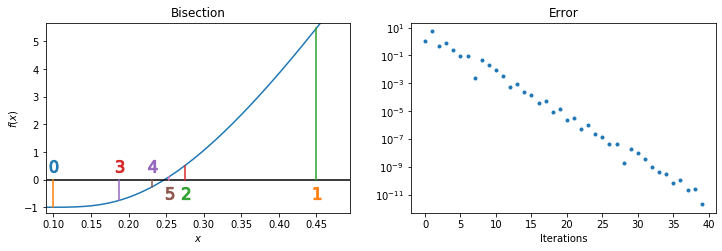

In [3]:
import scipy.optimize as opt
a = .1
b = .45

def cumf (x, func, xs) :
    xs.append(x)
    return func(x)

xs = []
nx = opt.bisect(cumf, a, b, args=(f, xs))

def show_converge(f, xs, a, b, maxIter, tag, diagline = True, txty = .5) :
    figure(figsize = [12, 3.5])
    subplot(1, 2, 1)

    xr = np.arange(a*.9, b*1.1, (b-a)/500.)
    bsv = np.array(list(map(f, xr)))

    plot(xr, bsv, '-')
    axhline(color = 'k');

    for i in range(maxIter) :
        plot([xs[i], xs[i]], [0, f(xs[i])])
        scatter(xs[i], txty*(1. if f(xs[i]) < 0 else -1.), 
                s=150, marker = "$%d$"% i)
        if diagline and i< (maxIter-1):
            plot([xs[i], xs[i+1]], [f(xs[i]), 0])

    xlim(a*.9, b*1.1);
    ylim(f(a) - .2, f(b) + .2);
    xlabel('$x$')
    ylabel('$f(x)$')
    title(tag)

    subplot(1, 2, 2)
    es = np.abs(list(map(f, xs)))
    semilogy(es, '.');
    xlabel('Iterations')
    title('Error');
    
show_converge(f, xs, .1, .45, 6, 'Bisection', False)

## Newton-Ralphson

* converges quadratically: $\vert \epsilon_{n+1} \vert \le c \; \epsilon_n^2$.

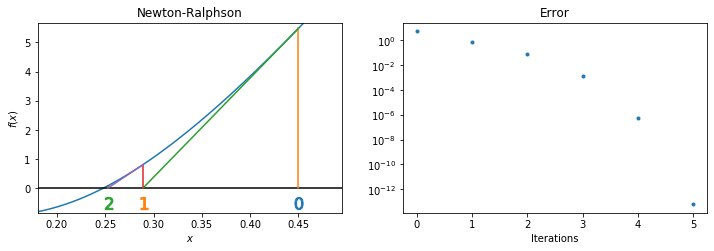

In [4]:
xs = []
nx = opt.newton(cumf, b, g, args=(f, xs))

show_converge(f, xs, 0.2, .45, 3, 'Newton-Ralphson', True)

* convergence is not guaranteed, it can fail around inflection point 
* guaranteed convergence if the function is convex everywhere.

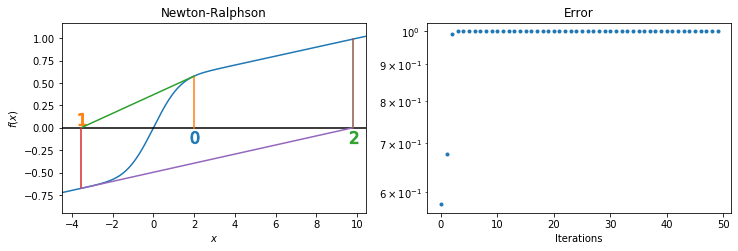

In [5]:
xs = []

try : 
    nx = opt.newton(cumf, 2, g2, args=(f2, xs))
except RuntimeError:
    pass

show_converge(f2, xs, -5, 9.5, 3, 'Newton-Ralphson', True, .1)

## Secant

* Similar to Newton-Raphson, but use previous valuations to approximate the derivatives

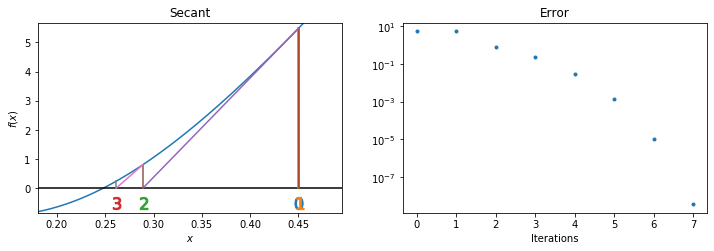

In [6]:
xs = []
g = lambda s, foo, bar : bs_vega(r=.05, s=100, k=150., sigma=s, t=1) 
nx = opt.newton(cumf, b, args=(f, xs))

show_converge(f, xs, 0.2, .45, 4, 'Secant', True)

Secant is also not guaranteed to converge.

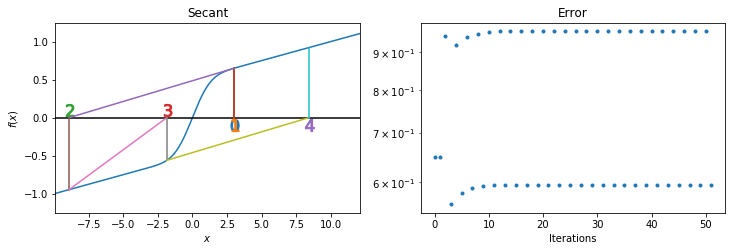

In [7]:
xs = []
try : 
    nx = opt.newton(cumf, 3, args=(f2, xs))
except RuntimeError:
    pass

show_converge(f2, xs, -11, 11, 5, 'Secant', True, .1)

## Brent
* An adaptive algorithm.
* Guaranteed to find a solution if initial guesses bucket the root
* Usually converges very fast
* Often the default choice in practice

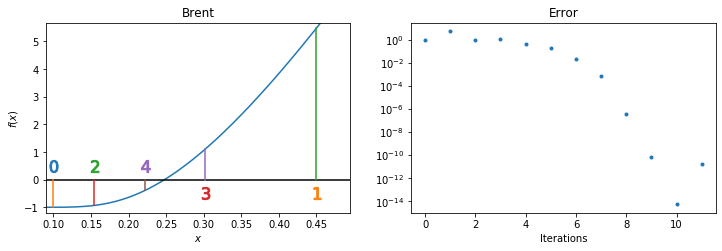

In [8]:
xs = []
g = lambda s, foo, bar : bs_vega(r=.05, s=100, k=150., sigma=s, t=1) 
nx = opt.brentq(cumf, a, b, args=(f, xs))

show_converge(f, xs, 0.1, .45, 5, 'Brent', False)

The challenging $\Phi(x) + .05x - 0.5 = 0$ converges under Brent:

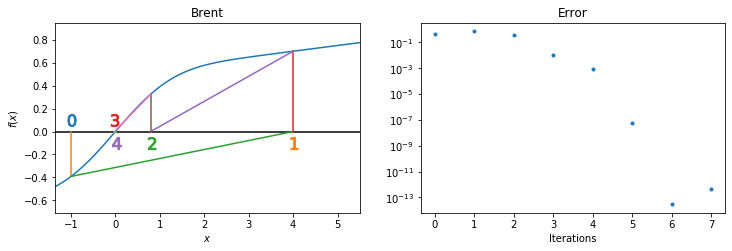

In [9]:
xs = []
nx = opt.brentq(cumf, -1, 4, args=(f2, xs))

show_converge(f2, xs, -1.5, 5, 5, 'Brent', True, .1)

# Interpolation

interpolate: verb, insert (something) between fixed points

## Common interpolation methods

From a discrete set of knot values $x_i, y_i$, find a function $f: x \rightarrow y$.
* that hits all the knot values

Common interpolation methods:
 
* Linear
* Polynomial
* Cubic spline

We will cover in detail:
* Tension spline
* Maximum entropy (future lecture)

## Linear interpolation


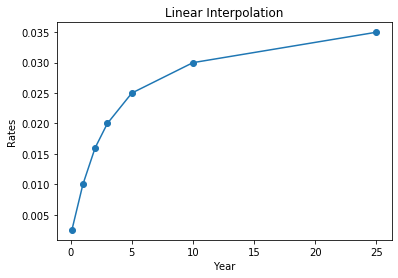

In [10]:
x = np.array([.1, 1.,2, 3., 5., 10., 25.])
y = np.array([.0025, .01, .016,.02, .025, .030, .035])
plot(x, y, '-o');
xlabel('Year')
ylabel('Rates');
title('Linear Interpolation');

## Piecewise constant interpolation

* values equals to the observation to the right (or left).
* simple (maybe even silly) but useful in curve building
* works well with bootstrap

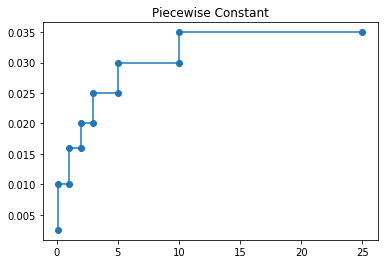

In [11]:
m = dict(zip(x, y))
m.update(dict(zip(x[:-1] + 1e-6, y[1:])))
k, v = zip(*sorted(m.items()))
plot(k, v, 'o-')
title('Piecewise Constant');

## Polynomial interpolation

* Fit a polynomial function of order $n-1$ to the $n$ observations.
* The exact solution is known as the Lagrange polynomials:

$$ p(x) = \sum_{i=0}^n(\prod_{1\le j \le n, j\ne i}\frac{x-x_j}{x_i-x_j})y_i $$

It is rarely used in practice because ...

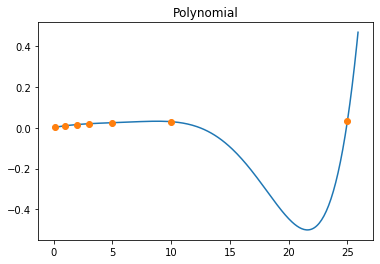

In [12]:
z = np.polyfit(x, y, len(x)-1)
p = np.poly1d(z)
x1d = arange(0, 26, .1)
plot(x1d, p(x1d))
plot(x, y, 'o');
title('Polynomial');

## Spline interpolation

Spline is an elastic string or pipe, used by draftsmen to draw smooth curves through fixed knots before the computer age:

<table style="border-style:hidden">
<tr>
<td style="border:none">
<img src=http://pages.cs.wisc.edu/~deboor/pix/boeing-spline.jpg width=400>
</td>
<td style="border:none">
<img src=http://pages.cs.wisc.edu/~deboor/pix/draftspline.jpg width=400>
</td>
</tr>
</table>

Spline interpolation is a mathematical model for the physical spline.

## Cubic spline

Cubic spline uses a 3rd order polynomial for each line section between knots

$$q_i(x) = a_i + b_i x + c_i x^2 + d_i x^3 \;,\;\; x_i < x < x_{i+1}$$ 

Enforce continuity up to the 2nd derivatives:

\begin{eqnarray}
q_{i-1}(x_i) &=& q_{i}(x_i) \\
q'_{i-1}(x_i) &=& q'_{i}(x_i) \\
q''_{i-1}(x_i) &=& q''_{i}(x_i)
\end{eqnarray}

## Boundary conditions

For $n$ knots, there are $n-1$ line sections with $4(n-1)$ parameters
 * $n$ constraint for the hitting the $n$ knot values
 * 3 continuity constraints for each intermediate knot: $3(n-2)$ 
 * $4n-6$ constraints in total 
 
Two additional constraints required to uniquely determine the cubic spline:
 * Natural Spline: $s''_1(x_1) = s''_{n-1}(x_{n}) = 0$
 * End slope conditions: $s'_1(x_1) = c_0, s'_{n-1}(x_{n}) = c_1$

## Cubic spline examples

Spline interpolation is very smooth

However, it does not preserve monotonicity and convexity 
  * it could overshoot
  * can result in arbitrages in many situations

In [13]:
import lin

ts = lin.RationalTension(0.)
ts.build(x, y)

x2 = np.array([.01, .03, .07, .1, .6])
y2 = np.array([.0095, .023, .035, .040, .042])

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(x1d, ts.value(x1d))
plot(x, y, 'o');
title('Cubic Spline');

subplot(1, 2, 2)
ts.build(x2, y2)
x2d = arange(.01, .65, .01)
plot(x2d, ts.value(x2d))
plot(x2, y2, 'o');
xlabel('Detachement')
title('CDO Tranche Expected Loss');

ModuleNotFoundError: No module named 'lin'

## Convexity

Option-like instruments' prices are convex functions:

$$ v(k) = \mathbb{E}[\max(\tilde s - k, 0)] $$

No arbitrage requires $\frac{\partial^2 v}{\partial k^2} > 0 $, because:

$$\small \frac{\partial^2}{\partial k^2}\mathbb{E}[\max(\tilde s-k, 0)] = \mathbb{E}[\frac{\partial^2}{\partial k^2} \max(\tilde s-k, 0)] = \mathbb{E}[\delta(\tilde s-k)] = p(k)
$$

* $\delta(x)$ is the Dirac delta function: $\int_{-\infty}^{\infty} f(x) \delta(x-a) dx = f(a)$
* $p(\cdot)$ is the probability density function of $\tilde s$
* The expected loss of a 0 to $k$ tranche is concave because:
  * $v(k) = \mathbb{E}[\min(\tilde l, k)] = k - \mathbb{E}[\max(k-\tilde l, 0)]$

## Exponential tension spline

A tension spline is originally defined as: $f^{(4)}(x) - \lambda f''(x) = 0$

* it models a physical spline stretched by a tension force 
* $\lambda$ is the ratio of the tension force over the rigidity of the spline
* it reduces to cubic spline when $\lambda = 0$
* with $\lambda \rightarrow \infty$, the spline is stretched to piece-wise straight lines
* the solution is a combination of exponential and linear functions of $x$

## Rational tension spline

Generic tension spline has the following property:

* has a scalar tension parameter $\lambda$
* when $\lambda = 0$, it reduces to cubic spline
* it converges to piecewise linear interpolation uniformly as $\lambda$ increases 

Rational tension spline is a convenient form of generic tension spline:

In [ ]:
import fmt

a, b, c, d, t = sp.symbols('a b c d t', real = True)
l = sp.symbols('lambda', positive=True)
f = sp.Function('f')
df = sp.Function("\dot{f}")
ddf = sp.Function("\ddot{f}")

r = (a + b*t + c*t**2 + d*t**3)/(1 + l*t*(1-t))
s_x, xi, xii, xi_ = sp.symbols('x, x_i, x_{i+1}, x_{i-1}', real=True)

fmt.displayMath(fmt.joinMath('=', f(t), r), fmt.joinMath('=', t, (s_x-xi)/(xii-xi)))

* it is more tractable than the exponential tension spline as only polynomial functions are involved 
* solvable the same way as cubic spline, $\lambda$ is a known parameter

## Constraints

The rationale tension spline's values and derivatives at $t=0$ and $t=1$:

In [ ]:
from fmt import math2df
pd.options.display.max_colwidth=300

def lincollect(e, tms) :
    m = sp.collect(sp.expand(e), tms, evaluate=False)
    return [m[k] if k in m else 0 for k in tms]

coefs = sp.Matrix([a, b, c, d])
drt0 = sp.Matrix([lincollect(r.diff(t, i).subs({t:0}), coefs) for i in range(3)])
drt1 = sp.Matrix([lincollect(r.diff(t, i).subs({t:1}), coefs) for i in range(3)])

In [ ]:
derivs = sp.Matrix([f(t), df(t), ddf(t)])
fmt.displayMath(fmt.joinMath('=', derivs.subs({t:0}), drt0), coefs, sep="", pre="\\scriptsize")
fmt.displayMath(fmt.joinMath('=', derivs.subs({t:1}), drt1), coefs, sep="", pre="\\scriptsize")

* Note the short-handed notation of $\ddot{f}(1) = \frac{d^2f(t)}{d t^2} \rvert _{t=1}$ etc. 
* $\lambda$ is a known constant
* Like cubic spline, there are $4(n-1)$ variables and constraints
* Solvable as a $4(n-1)$ dimensional linear systems ~ $O((4n)^3)$

## A better solution
Consider one line section between $[x_i, x_{i+1}]$:
* the four coefficients are fully determined by $f(0)$, $f(1)$, $\ddot{f}(0)$, $\ddot{f}(1)$:

In [ ]:
s_v = sp.Matrix([f(0), f(1), ddf(0), ddf(1)])
s_a = sp.Matrix([drt0[0, :], drt1[0, :], drt0[2, :], drt1[2, :]])

fmt.displayMath(s_a, fmt.joinMath('=', coefs, s_v), sep="", pre="\\scriptsize")

The linear system can be explicitly inverted (by `sympy`!):

In [ ]:
ss = sp.simplify(sp.expand(s_a.inv()))
fmt.displayMath(fmt.joinMath('=', coefs, ss), s_v, sep="\\scriptsize")

* the resulting $a, b, c, d$ ensures that the rational tension spline hits the target $f(t), \ddot{f}(t)$ at both ends of the line section.
* $\dot{f}(x_i)$ becomes linear combinations of $f$ and $\ddot f$ for line sections $[x_{i-1}, x_i]$ or $[x_i, x_{i+1}]$
  * the $\dot{f}(x_i)$ from the left and right line sections must equal

## Continuity conditions

Thus $\ddot{f}(x_i)$ at the knots are the only $n$ unknowns, which are solvable from the following $n$ constraints:
* End condition (natural spline): $\ddot{f}(x_1) = \ddot{f}(x_{n}) = 0$
* Continuity in $\dot{f}(x_i)$ for $n-2$ intermediate knots

Note that $f(\cdot)$ and its derivatives are continuous in $x$, not $t$:

$$
\frac{d^k f(t)}{dt^k} = (x_{i+1}-x_i)^k\frac{d^k f(x)}{dx^k} 
$$

* this is because $t = \frac{x-x_i}{x_{i+1} - x_i}$
* what if end conditions are given in $\dot{f}(x_1)$ and $\dot{f}(x_{n})$?

## Continuity in $f'(x_i)$

In [ ]:
xl, xr = sp.symbols('x_l, x_r')
vm = {xl:(xi-xi_), xr:(xii-xi)}

sl = sp.Matrix([f(xi_), f(xi), ddf(xi_)*xl**2, ddf(xi)*xl**2])
sr = sp.Matrix([f(xi), f(xii), ddf(xi)*xr**2, ddf(xii)*xr**2])
dl = sp.simplify(sp.expand((drt1[1,:]*ss*sl/xl)[0,0]))
dr = sp.simplify(sp.expand((drt0[1,:]*ss*sr/xr)[0,0]))

terms = sp.Matrix([ddf(xi_), ddf(xi), ddf(xii)])
d1 = sp.collect(sp.expand(dl - dr), terms, evaluate=False)

mr = sp.Matrix([sp.simplify(sp.simplify(d1[k]).subs(vm)) for k in terms])
rhs = sp.simplify(-d1[sp.S.One]).subs(vm)
fmt.displayMath(mr.T, terms, sep="")
fmt.displayMath("\;\;\;\;\;\;\; =", rhs, sep="")
#displayMath(*[fmt.joinMath('=', k, v) for k, v in vm.items()])

* this linear system can be written as a tri-diagonal matrix

## Tri-diagonal system

The following is the linear system of the 1st interpolation example with $\lambda = 2$:

In [ ]:
import trid
ts3 = trid.TridiagTension(2.)
ts3.build(x, y)

fmt.displayMath(sp.Matrix(np.round(ts3.a, 3)), fmt.joinMath('=', "\\boldsymbol{\\ddot{f}}", #ddf(s_x), 
                sp.Matrix(np.round(ts3.b, 4))), sep="", pre="\\small")

Thomas algorithm:
* a sparse version of the LU decomposition
* solves the tri-diagonal system in $O(n)$ operations

What is the complexity of regular LU decomposition?

## Tension spline examples

In [ ]:
def plotTension(x, y, lbds, xd) :
    plot(x, y, 'o');
    title('Tension Spline');

    for lbd in lbds:
        ts = lin.RationalTension(lbd)
        ts.build(x, y)
        plot(xd, ts.value(xd))
    
    legend(['data'] + ['$\lambda = %.f$' % l for l in lbds], loc='best');

lbds = (0, 2, 10, 50)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plotTension(x, y, lbds, x1d)
subplot(1, 2, 2)
plotTension(x2, y2, lbds, x2d)

* converges to piece wise flat curve uniformly with increasing $\lambda$

## Perturbation locality

Spline interpolation is global:
* changing a single knot affects the whole curve
* the perturbation is more localized with greater tension parameter $\lambda$

In [ ]:
def plotPerturb(x, y, yp, xd, lbds) :
    plot(x, yp-y, 'o')
    for lbd in lbds:
        ts = lin.RationalTension(lbd)
        ts.build(x, y)
        tsp = lin.RationalTension(lbd)
        tsp.build(x, yp)

        plot(xd, tsp.value(xd) - ts.value(xd))
        
    xlabel('$x$')
    ylabel('$y$')
    title('Changes in Spline')
    legend(['knots'] + ['$\lambda = %.f$' % l for l in lbds], loc='best');

dy = .01
figure(figsize=[12, 4])
subplot(1, 2, 1)
idx = 3
yp = np.copy(y)
yp[idx] *= 1. + dy

plotPerturb(x, y, yp, x1d, lbds)

subplot(1, 2, 2)
idx = 1
yp = np.copy(y2)
yp[idx] *= 1. + dy
plotPerturb(x2, y2, yp, x2d, lbds)

## Integral of tension spline

* Though complicated, the integral is analytical nonetheless
* The integral can be useful in deriving analytical pricing formulae
  * derived using `sympy`

In [ ]:
# now we compute the integral of r
num, den = sp.fraction(r)
t1, t2 = sp.solve(den, t)
sep = sp.S.One/(t-t1) - sp.S.One/(t-t2) 

tt = sp.symbols('tau', positive=True)
t1q, t1r = map(lambda x : sp.collect(sp.expand(x), t),  sp.div(num, t-t1))
t2q, t2r = map(lambda x : sp.collect(sp.expand(x), t),  sp.div(num, t-t2))
r_t1 = sp.integrate(sp.Rational(1,1)/(t-t1), (t, 0, tt))*t1r
r_t2 = sp.integrate(sp.Rational(1,1)/(t-t2), (t, 0, tt))*t2r
q_t1 = sp.integrate(t1q, (t, 0, tt))
q_t2 = sp.integrate(t2q, (t, 0, tt))
sums = sp.simplify(q_t1 - q_t2 + r_t1 - r_t2)/(t2-t1)/l

iv = sp.simplify(sp.collect(sp.simplify(sums), tt))
intg = sp.simplify(iv)

In [ ]:
s_s0, s_s1, s_s2, s_c1, s_c2, s_com = sp.symbols('s_0, s_1, s_2, c_1, c_2, c_0')
short = sp.simplify(sp.Rational(1, 2)/l/s_com*(s_s0 + s_s1*(s_c1 + s_c2) + s_s2*(s_c1 - s_c2)))
fmt.displayMath(fmt.joinMath('=', sp.Integral(r, (t, 0, tt)), short), pre="\\scriptsize ")

com = sp.sqrt(l*(l+4))

s0 = -d*tt**2*s_com - 2*tt*(c+d)*s_com
s1 = sp.log((sp.sqrt(l+4)+sp.sqrt(l))/(sp.sqrt(l+4)+sp.sqrt(l)-2*sp.sqrt(l)*tt))
s2 = sp.log((sp.sqrt(l+4)-sp.sqrt(l))/(sp.sqrt(l+4)-sp.sqrt(l)+2*sp.sqrt(l)*tt))

c1 = d*s_com/l + s_com*(b+c+d)
c2 = l*(2*a+b+c+d)+(2*c+3*d)

#short = sp.simplify(sp.Rational(1, 2)/l/com*(s0 + s1*(c1 + c2) + s2*(c1 - c2))).subs({s_com:com})

fmt.displayMath(fmt.joinMath('=', s_com, com), fmt.joinMath('=', s_s0, s0), pre="\\scriptsize ")
fmt.displayMath(fmt.joinMath('=', s_s1, s1), fmt.joinMath('=', s_s2, s2), pre="\\scriptsize ")
fmt.displayMath(fmt.joinMath('=', s_c1, c1), fmt.joinMath('=', s_c2, c2), pre="\\scriptsize ")

# Curve Building

Jessica Simpson: I love my curves

## Curve building fundamentals

* Inputs: prices of benchmark instruments of the same risk factor, at different maturities
* Outputs: a single curve for the underlying factor that explains all observed prices to adequate precision.
* Curve building is a fundamental problem in Finance, it can become extremely complicated

## Common types of curves

* Interest rate: OIS, Libor 3M/6M etc,
* CDS (credit default swap)
* Commodity
* FX
* Inflation

## Curve terminology


$b(t)$ is the price of risk free zero coupon bond maturing at $t$:

* Zero rate (or spot rate, yield, internal rate of return): 

$$r(t) = -\frac{1}{t}\log(b(t)) \iff b(t) = e^{-r(t) t} $$

* Forward rate: 

$$f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} \iff b(t) = e^{-\int_{0}^t f(s) ds} $$

* Swap rate (continuous coupon): 

$$s(t) = \frac{1 - b(t)}{\int_0^t b(s) ds} \iff s(t) \int_0^t b(s) ds + b(t) = 1 $$ 




## Relationship between rates

In [ ]:
dt = .1
t = np.arange(dt, 30, dt)

tn = np.array([0, 5, 30])
rn = np.array([.04, .06, .055])

cv = lin.RationalTension(2.)
cv.build(tn, rn)

f = cv(t) + t*cv.deriv(t)
b = exp(-t*cv(t))
intb = np.cumsum(b*dt)
s = (1-b)/intb

plot(t, cv(t));
plot(t, f)
plot(t, s)

legend(['Zero Rate', 'Forward Rate', 'Swap Rate'], loc='best');
xlabel('Time');

* zero rate is the average of forward rate:

$$ r(t) = \frac{1}{t} \int_0^t f(s) ds $$

* zero rate is an approximation to the swap rate (when $b(t) \approx 1$):

$$ s(t) = \frac{1 - b(t)}{\int_0^t b(s) ds} \approx \frac{1 - e^{-r(t)t}}{t} \approx \frac{r(t) t}{t} = r(t) $$


## Introduction to CDS

| No Default | With Default |
| :----: | :-----: |
| <img src="img/cds1.png"> | <img src="img/cds2.png"> |

CDS is an insurance against a reference entity's default risk

* protection buyer: makes quarterly payments of notional$\times$spread$\times$daycount.
* protection seller: pays the default loss of notional$\times$(1-rec) when the reference entity defaults before CDS maturity.

## Long or short ?

Important market convention: long position is **always** equivalent to owning the underlying bond

* receiver swap is long $\iff$ own a fixed coupon risk free bond 
* sell CDS protection is long $\iff$ own a fixed coupon risky bond 

Deltas are **always** communicated by perturbing the market to the longer side, i.e., the direction where long positions makes money:

* interest rate decrease by 1bps
* credit spread compress by 1bps
* positive deltas **always** corresponds to long positions

Often the risk computation is done by bumping rates +1bps, then flipping the signs before the final reporting.

## IR vs credit terminologies

In a very loose way, the following terms are the counterparts between IR and credit/CDS market (all in continuous compounding):

| | Interest Rate | Credit |
| :---: | :----: | :----: |
| primary state variable | discount factor $b(t)$ | survival probability $p(t)$ |
| yield, IRR | zero rate <br>$r(t) = -\frac{1}{t}\log(b(t))$ | quoted spread <br> $q(t) \approx -\frac{1 - \text{rec}}{t}\log(p(t))$ |
|forward rate| forward interest rate <br> $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} $ | hazard rate <br> $h(t) = -\frac{1}{p(t)}\frac{d p(t)}{d t} $ |
|par swap rate $s(t)$ | par IR swap rate | par CDS spread |
| cumulative yield | $y(t) = -\log(b(t))$ | $g(t) = -\log(p(t)) $ |

## CDS benchmark instruments

The following is a representative set of CDS quotes observed in the market:

In [ ]:
import inst

def flatCurve(rate) :
    return lambda t : np.exp(-rate*t)

disc = flatCurve(.01)

terms = np.array([.25, .5, 1., 2, 3, 4, 5, 6, 7, 8, 10])
qs = np.array([80, 85, 95, 154, 222, 300, 385, 410, 451, 470, 480])

cps = np.ones(len(terms))*100
insts = [inst.CDS(m, c*1e-4, .4) for m, c in zip(terms, cps)]

#compute the upfront PV of the benchmark instruments
ufr = np.array([i.pv01(disc, flatCurve(f*1e-4))*(c-f)*1e-4 for i, f, c in zip(insts, qs, cps)])

mat_tag = 'Maturity (Y)'
pd.set_option('precision', 4)

cds_data = pd.DataFrame({mat_tag:terms, 'Coupon(bps)':cps, 'Quoted Spread(bps)':qs, 'PV (% Points)': ufr*100.}).set_index(mat_tag)
fmt.displayDF(cds_data.T, "4g", fontsize=2)
benchmarks = dict(zip(insts, ufr))

* the CDS contract have standardised semi-annual maturities, on Mar-20 and Sep-20
* it usually costs more per annum for longer term contracts
* for most names, there are only a few liquid CDS instruments, referred as the benchmark instruments
* quoted spreads is a way to communicate the upfront payment, it loosely corresponds to the zero rate or yield in IR

## What to interpolate?

It is important to choose the right quantity to interpolate

* There are many potential choices, e..g: $f(t), f'(t)$ or $\int_0^t f(s) ds$ etc.
* Which variable is a natural fit for tension spline's stretch operation?
* We want the variable itself to be continuous, but can live with the discontinuities in $f'(t)$ when $\lambda \rightarrow \infty$

Industry standard:
$$p(t) = e^{-\int_0^t h(s) ds}$$
* build piecewise flat curve in hazard rate $h(t)$ for CDS:
* where $p(t)$ is the survival probability of the reference entity at time $t$. 

this is quite odd, why don't we use a continuous interpolation in $h(t)$?
* such as piece wise linear or cubic spline?

## Triangular dependency

The objective:
* build a curve in hazard rate $\bs h(t)$ that exactly reproduce all observed CDS prices quoted in $\bs q(t)$

| |$h(3m)$|$h(6m)$|$h(1Y)$|$h(2Y)$|$h(5Y)$|
|:----:|:----:| :----: | :----: | :----: | :----: | :----: |
|$q(3m)$| X | | | | | 
|$q(6m)$| * | X | | | | 
|$q(1Y)$| * | * | X | | | 
|$q(2Y)$| * | * | * | X | | 
|$q(5Y)$| * | * | * | * | X |

Bootstrap is the standard method to build curves with triangular dependency:
* Solve the knot values one by one, using benchmark instruments with increasing maturities

## Piecewise flat bootstrap

* This is the standard approach to build CDS curves in the industry
* $g(t)$ is the cumulative hazard: $g(t) = \int_0^t h(s) ds = -\log(p(t))$
* Piecewise flat in hazard rate $h(t)$ is equivalent to piecewise linear in $g(t)$

In [ ]:
cdspv = inst.cdspv(disc, inst.zero2disc)

hlin = lin.PiecewiseLinear()
hlin.build(terms, terms*.01)
hlin.addKnot(0, 0)
hlin = inst.bootstrap(benchmarks, hlin, cdspv, bds = [-1., 1.])
cds_data['PV Error (bps) - Linear'] = np.round([1e4*(cdspv(i, hlin) - benchmarks[i]) for i in insts], 4)

xs = np.arange(.01, 10, .01)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(xs, hlin(xs))
plot(terms, hlin(terms), 'o')
xlabel('Time')
title('$g(t)$');

subplot(1, 2, 2)
plot(xs, hlin.deriv(xs))
plot(terms, hlin.deriv(terms-1e-4), 'o')
xlabel('Time')
title('$h(t)$');

## Pros and cons of piecewise flat bootstrap

* All benchmark prices are exactly matched, after bootstrap with piecewise flat hazard rate.
* Discontinuity in hazard rate causes hedging problems, risk profiles jump over the roll dates.

In [ ]:
fmt.displayDF(cds_data.T, "4g", fontsize=2)

How to remove the discontinuity in hazard rate?
* applying cubic spline to hazard rate seems to be a natural idea, does it work?

## Cumulative hazard

The cumulative hazard $g(t)$ is a suitable variable for the tension spline interpolation:

$$g(t) = \int_0^t h(s) ds = -\log(p(t))$$

* $g(t)$ is continuous and monotonic, 1 to 1 with $p(t)$
* $g(0) = 0$, the boundary condition is well defined
* $h(t) = g'(t)$ can be discontinuous when $\lambda \rightarrow \infty$, this reverts to the standard method of piecewise flat hazard rate
* with finite $\lambda$, hazard rate is smooth and continuous

This argument carries over to the interest rate curve building:

* the cumulative yield, $y(t) = -\log(b(t))$, is a suitable variable to apply tension spline

## Bootstrap with tension spline

In [ ]:
def plotboot(tsit, lbd, ax, tagsf) :
    xlabel('Time')    
    
    lbd_tag = '$\\lambda=%.f$' % lbd
    df = pd.DataFrame({'$t$':xs}).set_index(['$t$'])
    
    for tag, f in tagsf :
        df[tag] = f(tsit, xs) 
    
    df.plot(ax = ax, secondary_y = [tagsf[0][0]], title = 'Tension Spline ' + lbd_tag)
    plot(terms, tsit(terms), 'o')

tagsf = [("$g(t)$", lambda cv, xs : cv(xs)), ("$h(t)$", lambda cv, xs : cv.deriv(xs))]

lbds = [0, 2, 10, 100]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

es = []

for lbd, ax in zip(lbds, axes.flatten()) :
    tsit, e = inst.iterboot(benchmarks, cdspv, lbd=lbd, x0=0, its=1)
    plotboot(tsit, lbd, ax, tagsf)  
    es.append(e[0])

## Bootstrapping with global interpolation

The benchmark CDS won't reprice exactly after the bootstrapping with tension spline:
* Changes in longer maturity affects the shorter end of the curve
* The dependency matrix is no longer triangular, but close


In [ ]:
df = pd.DataFrame(np.array(es)*1e4, index=['Fit Error (bps) $\\lambda$=%g' % l for l in lbds], 
                  columns = ['%gY' % t for t in terms])
fmt.displayDF(df, "4f", fontsize=2)

Recall how we force matrix to be triangular using QR algorithm?

## Iterative algorithm

Iteration is an effective method for near triangular dependency:

$$\bs x^{i+1} = f(\bs x^i)$$

* where $f(\cdot)$ represent the bootstrap operation, $\bs x^i$ is knot solutions
* $\bs x^0$ is a initial guess, e.g. a flat curve
* simple and effective, usually outperforms sophisticated optimizers

## Iteration with mixing

Mixing the old and new results between iterations improves stability:

$$\bs x^{i+1} = m f(\bs x^i) + \left(1-m\right) \bs x^i$$

* $m = 0.5$ is often a good choice

In [ ]:
figure(figsize=[12, 4])
ax = subplot(1, 2, 1)

tsit, e = inst.iterboot(benchmarks, cdspv, x0=0, lbd = lbds[0], its=6)
tsit1, e1 = inst.iterboot(benchmarks, cdspv, x0=0, lbd = lbds[0], mixf=0.5, its=6)

plotboot(tsit, lbds[0], ax, tagsf)    

subplot(1, 2, 2)
semilogy(range(1, len(e)+1), np.transpose([np.linalg.norm(e, 2, 1)*1e4, np.linalg.norm(e1, 2, 1)*1e4]), 'o-')
legend(['no mixing $m=0$', 'mixing $m=0.5$'], loc='best')

xlabel('Iteration')
ylabel('bps')
title('L-2 norm of error (bps)');

## Effects of tension parameter $\lambda$

* No visible difference in $g(t)$
* Big difference in the hazard rate $h(t)$
  * the smaller $\lambda$, the smoother the $h(t)$

In [ ]:
def pv_lbds(bms, cdspv, lbds, x0) :
    cvs = []
    for lbd in lbds:
        cv, e = inst.iterboot(bms, cdspv, x0, lbd, mixf = 0.5)
        cvs.append(cv)
    
    return cvs

In [ ]:
lbds = (0, 2, 10, 50)
tags = ['$\\lambda=%.f$' % l for l in lbds]
cv0 = pv_lbds(benchmarks, cdspv, lbds, 0)

figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(xs, np.array([cv(xs) for cv in cv0]).T);
title('$g(t)$')
xlabel('$t$')

subplot(1, 2, 2)
plot(xs, np.array([cv.deriv(xs) for cv in cv0]).T);
legend(tags, loc='best');
title('$h(t)$');
xlabel('$t$');

## Perturbation locality

Changes in hazard rates are more localized with larger $\lambda$
* A highly desirable property in practice

In [ ]:
def showPerts(bms, bms_ps, cdspv, lbds, x0, pertf) :
    cv0 = pv_lbds(bms, cdspv, lbds, x0=x0)
    cvp1, cvp2 = [pv_lbds(b, cdspv, lbds, x0=x0) for b in bms_ps]
    
    lbd_tags = ['$\\lambda=%.f$' % lbd for lbd in lbds]

    figure(figsize=[12, 4])

    subplot(1, 2, 1)
    plot(xs, 1e4*np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp1)]).T);
    xlabel('Tenor')
    ylabel('$\Delta h(t)$ (bps)')
    title('1bps Spread Perturbation @t=%.2f' % pts[0])
    legend(lbd_tags, loc='best');
    plot(terms, 1e4*np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp1)]).T, '.');

    subplot(1, 2, 2)
    plot(xs, 1e4*np.array([pertf(f, g)(xs) for f, g in zip(cv0, cvp2)]).T);
    xlabel('Tenor')
    ylabel('$\Delta h(t)$ (bps)')
    title('1bps Spread Perturbation @t=%.2f' % pts[1])
    legend(lbd_tags, loc='best');
    plot(terms, 1e4*np.array([pertf(f, g)(terms) for f, g in zip(cv0, cvp2)]).T, '.');
    
    
pts = [.5, 5]
bms_ps = [{k if k.maturity != pt else inst.CDS(k.maturity, k.coupon-1e-4, k.recovery) : v 
        for k, v in benchmarks.items()} for pt in pts]
    
showPerts(benchmarks, bms_ps, cdspv, lbds, 0, lambda f, g : lambda xs : f.deriv(xs) - g.deriv(xs))

## Interpolate the hazard rate?

The result is disastrous:

* When $\lambda \rightarrow \infty$, it approaches linear interpolation in the hazard rate
* Linearly interpolating $h(t)$ leads to zigs and zags

In [ ]:
hazard_pv = inst.cdspv(disc, inst.fwd2disc)
x0 = .01
chartf = [('$h(t)$',  lambda cv, xs : cv(xs)), ('H(t)', lambda cv, xs : cv.integral(xs))]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])

lbds = (0, 20)
tsit0, e0 = inst.iterboot(benchmarks, hazard_pv, x0, lbds[0], mixf=.5)
plotboot(tsit0, lbds[0], axes[0], chartf)    

tsit1, e1 = inst.iterboot(benchmarks, hazard_pv, x0, lbds[1], mixf=.5)
plotboot(tsit1, lbds[1], axes[1], chartf) 

Perturbation in a single tenor generates waves throughout the hazard rate term structure.

In [ ]:
showPerts(benchmarks, bms_ps, hazard_pv, lbds, x0, lambda f, g : lambda xs : f(xs) - g(xs))

## State variable

Generally, it is always better to interpolate the state variable:

* state variable is the primary determinant of the benchmark price, such as the cumulative hazard $g(t) = -\log(p(t))$
* the derivatives, like $h(t) = g'(t)$, only changes the prices through its cumulative effects (integral), which leads to zigzags and waves when combined with a continuous interpolation.

bootstrap derivative variables + continuous interpolation = **DISASTER**

# Assignments

Recommended reading:

* Bindel and Goodman: Chapter 6.1, 6.2, 7.1

* Andersen and Piterbarg: Chapter 6.1-6.2, 6.A

Homework:

* Complete [homework set 4](http://yadongli.github.io/nyumath2048/)